# Python for Scientific Computing
## Max Planck Computing and Data Facility, Garching

# Example: Heat Equation

* toy problem: (constant) diffusion on a 2d periodic grid $u_t = \alpha \Delta u$
* explicit time stepping
* **lecture example**
    * finite difference Laplacian operator, 5-point stencil
    * formula for time update of $u$ at position $x_i,y_j$ from time $t_n$ to $t_{n+1}$: 
    $$ u_{i,j}^{(n+1)} = u_{i,j}^{(n)} + \frac{\alpha \Delta t}{\Delta x^2} \left( 
    u_{i-1,j}^{(n)}
    +u_{i+1,j}^{(n)}
    +u_{i,j-1}^{(n)}
    +u_{i,j+1}^{(n)}
    -4u_{i,j}^{(n)}
    \right) $$
* **exercise**
    * use a 9-point stencil for the finite difference Laplacian operator
    * formula for time update of $u$ at position $x_i,y_j$ from time $t_n$ to $t_{n+1}$: 
    $$ u_{i,j}^{(n+1)} = u_{i,j}^{(n)} + \frac{\alpha \Delta t}{3 \Delta x^2} \left( 
      u_{i+1,j}^{(n)} + u_{i-1,j}^{(n)} + u_{i,j+1}^{(n)} + u_{i,j-1}^{(n)}
    + u_{i+1,j+1}^{(n)} + u_{i-1,j-1}^{(n)} + u_{i+1,j-1}^{(n)} + u_{i-1,j+1}^{(n)} - 8u_{i,j}^{(n)}
    \right) $$
* implemente various approaches
    * naive Python implementation
    * NumPy variants
    * Cython
    * Numba
* measure, compare, improve

In [1]:
# Technical detail: limit the number of threads to allow for a fair comparison,
#                   some NumPy expressions would try to parallelize automatically
import os
for VAR in ["OMP_NUM_THREADS", "NUMBA_NUM_THREADS"]:
    if VAR not in os.environ:
        os.environ[VAR]="1"
    print("{}={}".format(VAR, os.environ[VAR]))
import numpy as np

OMP_NUM_THREADS=1
NUMBA_NUM_THREADS=1


## Infrastructure code: parameters, init(), main_loop()

In [2]:
# parameters (global, for convenience)
n_iterations = 50
n_points = 254
dt = 0.12
D = 0.8

In [3]:
def init(val=0.5):
    """Set up a 2d NumPy array with some initial value pattern."""
    x = np.linspace(0., 4.*np.pi, num=n_points+2)
    y = np.linspace(0., 4.*np.pi, num=n_points+2)
    grid = val * np.outer(np.sin(x)**4, np.sin(y)**4)
    return grid

In [4]:
def main_loop(evolve_func, grid):
    """Main loop function, calling evolve_func on grid."""
    grid_tmp = np.empty_like(grid)
    for i in range(1, n_iterations+1):
        evolve_func(grid, grid_tmp, n_points, dt, D)
        # swap references, do not copy
        grid_foo = grid
        grid = grid_tmp
        grid_tmp = grid_foo
    return grid

## 1. A naive pure Python implementation

In [5]:
def apply_periodic_bc_python(grid, n_points):
    """Explicitly apply periodic boundary conditions, via Python loops."""
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

In [6]:
def evolve_python(grid, grid_tmp, n_points, dt, D):
    """Time-step using 5-pt stencil, as presented in the lecture."""
    apply_periodic_bc_python(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

In [7]:
%%time
grid = init()
solution_python = main_loop(evolve_python, grid)

CPU times: user 4 s, sys: 4.15 ms, total: 4.01 s
Wall time: 4.01 s


In [8]:
def evolve_python_nine(grid, grid_tmp, n_points, dt, D):
    """Time-step using 9-pt stencil."""
    apply_periodic_bc_python(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + 1./3. * dt * D * (
                  grid[i-1, j]   + grid[i+1, j]   + grid[i,   j-1]   + grid[i, j+1]
                + grid[i-1, j-1] + grid[i-1, j+1] + grid[i+1, j-1] + grid[i+1, j+1]
                - 8.0 * grid[i, j])

In [9]:
%%time
grid = init()
solution_python_nine = main_loop(evolve_python_nine, grid)

CPU times: user 6.47 s, sys: 30 µs, total: 6.47 s
Wall time: 6.46 s


In [10]:
import matplotlib.pyplot as plt

def plot_grids(grid_1, grid_2):
    f = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.pcolormesh(grid_1.T)
    plt.axis('image')
    plt.title('grid_1')
    plt.subplot(122)
    plt.pcolormesh(grid_2.T)
    plt.axis('image')
    l = plt.title('grid_2')

plot_grids(solution_python, solution_python_nine)

In [11]:
# look at the deviation of the solutions between the 5pt and the 9pt stencil
rel = np.max(np.abs(solution_python - solution_python_nine))/np.max(np.abs(solution_python))
print(rel)

0.00013159826577225403


## 2. NumPy implementations

In [12]:
def evolve_numpy_slicing_nine(grid, grid_tmp, n_points, dt, D):
    """Time-step using 9-pt stencil."""
    apply_periodic_bc_python(grid, n_points)
    # stencil formula
    grid_tmp[1:-1, 1:-1] = grid[1:-1, 1:-1] + 1./3. * dt * D * (
                           grid[0:-2, 1:-1] 
                         + grid[2:  , 1:-1]
                         + grid[1:-1, 0:-2]
                         + grid[1:-1, 2:  ]
                         + grid[0:-2, 0:-2]
                         + grid[0:-2, 2:  ]
                         + grid[2:  , 0:-2]
                         + grid[2:  , 2:  ]
                   - 8.0 * grid[1:-1, 1:-1])

In [13]:
%%time
grid = init()
solution_numpy_slicing_nine = main_loop(evolve_numpy_slicing_nine, grid)

CPU times: user 52.4 ms, sys: 42 µs, total: 52.4 ms
Wall time: 51.3 ms


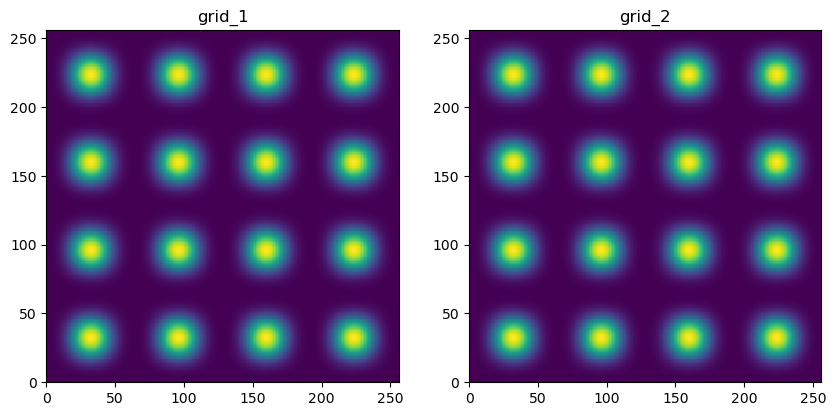

In [14]:
plot_grids(solution_python, solution_numpy_slicing_nine)

## 3. Cython implementation

In [15]:
%load_ext Cython

In [16]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math 
# --annotate

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
cpdef apply_periodic_bc_cython(np.ndarray[np.float64_t, ndim=2] grid, int n_points):
    cdef int i, j
    for j in range(n_points + 2):
        grid[         0, j] = grid[n_points, j]  # grid[ 0, j] = grid[-2, j]
        grid[n_points+1, j] = grid[       1, j]  # grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i, n_points+1] = grid[ i,        1]  # grid[ i,-1] = grid[ i, 1]
        grid[ i,          0] = grid[ i, n_points]  # grid[ i, 0] = grid[ i,-2]

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
def evolve_cython_nine(np.ndarray[np.float64_t, ndim=2] grid,
                       np.ndarray[np.float64_t, ndim=2] grid_tmp,
                       int n_points, double dt, double D):
    cdef int i, j
    apply_periodic_bc_cython(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            grid_tmp[i, j] = grid[i, j] + 1./3. * dt * D * (
                  grid[i-1, j]   + grid[i+1, j]   + grid[i,   j-1]   + grid[i, j+1]
                + grid[i-1, j-1] + grid[i-1, j+1] + grid[i+1, j-1] + grid[i+1, j+1]
                - 8.0 * grid[i, j])

In file included from /opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/khr/.cache/ipython/cython/_cython_magic_b0b380ece8b840d5fe230a61a81b3b9e.c:780:
/opt/apps/anaconda/3/2023.03/envs/pyhpc/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [17]:
%%time
grid = init()
solution_cython_nine = main_loop(evolve_cython_nine, grid)

CPU times: user 21.2 ms, sys: 14 µs, total: 21.2 ms
Wall time: 20.6 ms


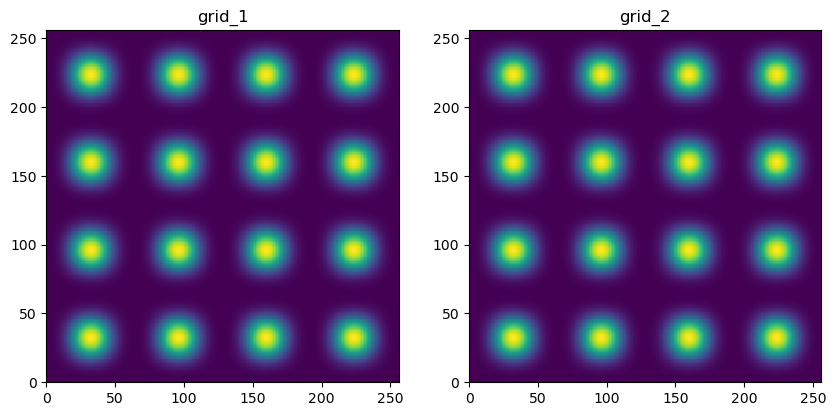

In [18]:
plot_grids(solution_python, solution_cython_nine)

## 4. Numba implementation

In [19]:
from numba import jit

In [20]:
@jit(nopython=True)
def apply_periodic_bc_numba(grid, n_points):
    """Explicitly apply periodic boundary conditions, via Python loops."""
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

In [21]:
@jit(nopython=True)
def evolve_numba_nine(grid, grid_tmp, n_points, dt, D):
    """Time-step using 9-pt stencil."""
    apply_periodic_bc_numba(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + 1./3. * dt * D * (
                  grid[i-1, j]   + grid[i+1, j]   + grid[i,   j-1]   + grid[i, j+1]
                + grid[i-1, j-1] + grid[i-1, j+1] + grid[i+1, j-1] + grid[i+1, j+1]
                - 8.0 * grid[i, j])

In [22]:
# run once without timing in order to compile, do the timing below
grid = init()
solution_numba_nine = main_loop(evolve_numba_nine, grid)

In [23]:
%%time
grid = init()
solution_numba_nine = main_loop(evolve_numba_nine, grid)

CPU times: user 5.45 ms, sys: 20 µs, total: 5.47 ms
Wall time: 4.74 ms


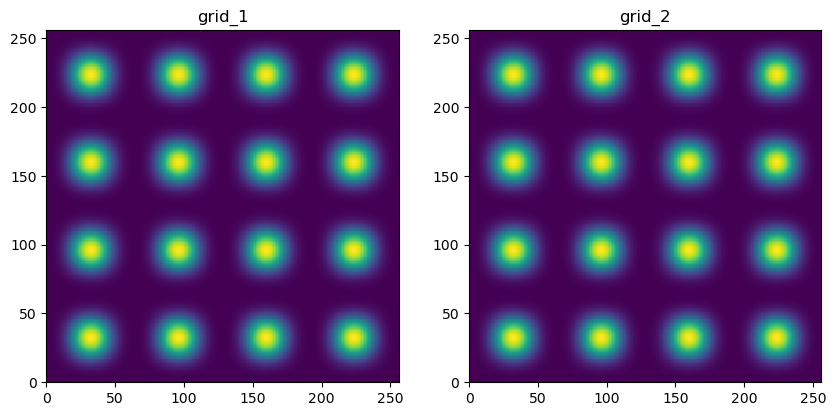

In [24]:
plot_grids(solution_python, solution_numba_nine)

## Optional exercise parts
* Further increase the order/stencil width of the Laplacian (requires to increase the width of the ghost cells for the periodic boundary conditions)
* Implement functions to write the grid every few time steps to a HDF5 file (and to read it in again)
* Implement a restart functionality: restart the simulation from a saved HDF5 file
* Implement reading in a parameter file in YAML format for the simulation parameters (number of iterations, number of points, timestep...)
* Complete the MPI implementation in `Diffusion_MPI.py` that uses a domain decomposition approach (complete communication of boundaries and communication of whole grid to root for plotting)

In [25]:
# Optional exercise: HDF5 checkpointing and resuming

import h5py

def save_checkpoint(numpy_grid, file_name="diffusion.hdf5"):
    with h5py.File(file_name, 'w') as fp:
        fp["grid"] = numpy_grid
        # Bonus: save simulation parameters as attributes (present as global variables)
        fp.attrs["n_iterations"] = n_iterations
        fp.attrs["n_points"] = n_points
        fp.attrs["dt"] = dt
        fp.attrs["D"] = D

def load_checkpoint(file_name="diffusion.hdf5"):
    with h5py.File(file_name, 'r') as fp:
        numpy_grid = fp["grid"][:]
        return numpy_grid, fp.attrs["n_iterations"], fp.attrs["n_points"], fp.attrs["dt"], fp.attrs["D"]

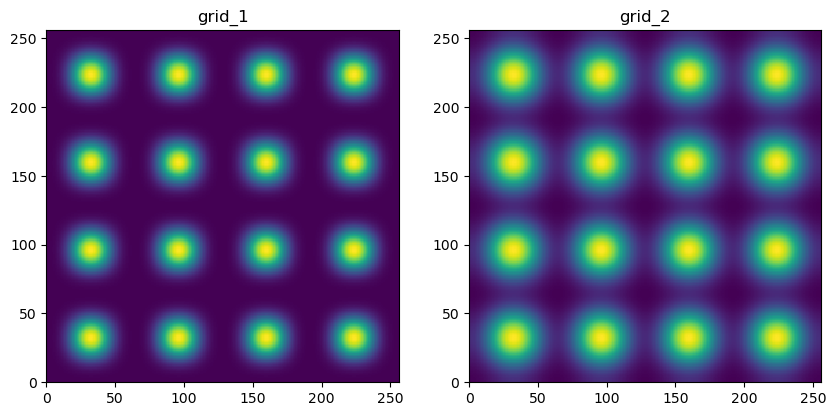

In [26]:
# Optional exercise: Test HDF5 checkpointing and resuming
grid = init()
solution_numba_nine = main_loop(evolve_numba_nine, grid)
save_checkpoint(solution_numba_nine)

# for the present test, explicitly delete the objects we need to read back in
del grid, n_iterations, n_points, dt, D

grid, n_iterations, n_points, dt, D = load_checkpoint()

n_iterations *= 10  # let's run the simulation a bit longer
solution_resumed = main_loop(evolve_numba_nine, grid)

plot_grids(solution_numba_nine, solution_resumed)

In [27]:
# save/restore parameters via YAML
import yaml

def save_parameters(par):
    with open("parameters.yaml", 'w') as fp:
        yaml.safe_dump(par, fp, default_flow_style=False, indent=4)

def load_parameters():
    with open("parameters.yaml", 'r') as fp:
        par = yaml.safe_load(fp)
    return par


# parameters
n_iterations = 50
n_points = 254
dt = 0.12
D = 0.8

# build a dict with the parameters
par = {}
par["n_iterations"] = n_iterations
par["n_points"] = n_points
par["dt"] = dt
par["D"] = D

save_parameters(par)
par_restored = load_parameters()

assert(par == par_restored)